In [1]:
import pandas as pd
import numpy as np
import csv
import cv2
from math import sin, cos, radians
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.patches import Arc
import seaborn as sns
from shapely.geometry import Polygon, Point
from shapely.geometry.polygon import orient
from shapely.geometry import LineString
import sklearn
from sklearn import cluster
from sklearn import datasets
from sklearn import decomposition
from scipy import stats
import umap
import os
os.environ['OMP_NUM_THREADS'] = '1'


In [2]:
# CHARGE AND TRANSFORM DATA

df_off_reb = pd.read_csv('csv/off_reb.csv')
df_def_reb = pd.read_csv('csv/def_reb.csv')
df_off_reb['kind']="offensive"
df_def_reb['kind']="defensive"
df = pd.concat([df_off_reb, df_def_reb], axis=0)

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1286 entries, 0 to 694
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   video_name    1286 non-null   object 
 1   x_2D_shot     1034 non-null   float64
 2   y_2D_shot     1034 non-null   float64
 3   x_2D_rebound  1021 non-null   float64
 4   y_2D_rebound  1021 non-null   float64
 5   kind          1286 non-null   object 
dtypes: float64(4), object(2)
memory usage: 70.3+ KB


In [4]:
'''
def POINTS_COURT (side_court):

    court = cv2.imread('images/basketball_halfcourt.jpg')
    cv2.imshow('Basketball half court', court)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    plt.imshow(cv2.cvtColor(court, cv2.COLOR_BGR2RGB))
    plt.title(f"Select 6 key points in the {side_court} court 2D")
    points_2D = plt.ginput(6)
    plt.close()

    print(f"Points selected in the 2D {side_court} court:", points_2D)

    return points_2D

half_court_2D = POINTS_COURT("half court")
half_court = pd.DataFrame(half_court_2D, columns=['X', 'Y'])
half_court.to_csv("csv/points2D_half_court.csv", index=False)
'''

'\ndef POINTS_COURT (side_court):\n\n    court = cv2.imread(\'images/basketball_halfcourt.jpg\')\n    cv2.imshow(\'Basketball half court\', court)\n    cv2.waitKey(0)\n    cv2.destroyAllWindows()\n\n    plt.imshow(cv2.cvtColor(court, cv2.COLOR_BGR2RGB))\n    plt.title(f"Select 6 key points in the {side_court} court 2D")\n    points_2D = plt.ginput(6)\n    plt.close()\n\n    print(f"Points selected in the 2D {side_court} court:", points_2D)\n\n    return points_2D\n\nhalf_court_2D = POINTS_COURT("half court")\nhalf_court = pd.DataFrame(half_court_2D, columns=[\'X\', \'Y\'])\nhalf_court.to_csv("csv/points2D_half_court.csv", index=False)\n'

In [5]:
# FIND THE HOMOGRAPHY MATRIX

left_court = pd.read_csv('csv/points2D_left_court.csv', skiprows=1, header=None).apply(tuple, axis=1).tolist()
right_court = pd.read_csv('csv/points2D_right_court.csv', skiprows=1, header=None).apply(tuple, axis=1).tolist()
half_court = pd.read_csv('csv/points2D_half_court.csv', skiprows=1, header=None).apply(tuple, axis=1).tolist()

left_court = np.array(left_court, dtype=np.float32)
right_court = np.array(right_court, dtype=np.float32)
half_court = np.array(half_court, dtype=np.float32)

H_left, status = cv2.findHomography(left_court, half_court, cv2.RANSAC)
H_right, status = cv2.findHomography(right_court, half_court, cv2.RANSAC)

In [6]:
# TRANSFORMATION OF THE POINT THROUGH HOMOGRAPHY MATRIX

df['court'] = df['x_2D_shot'].apply(lambda x: "left" if x < 700 else "right")

def apply_homography(x, y, H):
    point = np.array([x, y, 1], dtype=np.float32)
    transformed_point = H @ point  # Transformación
    transformed_point /= transformed_point[2]  # Normalizar
    return transformed_point[0], transformed_point[1]

df['x_shot'] = np.nan
df['y_shot'] = np.nan
df['x_rebound'] = np.nan
df['y_rebound'] = np.nan

for index, row in df.iterrows():
    if row['court'] == 'left':
        x_shot, y_shot = apply_homography(row['x_2D_shot'], row['y_2D_shot'], H_left)
        x_rebound, y_rebound = apply_homography(row['x_2D_rebound'], row['y_2D_rebound'], H_left)
    else:
        x_shot, y_shot = apply_homography(row['x_2D_shot'], row['y_2D_shot'], H_right)
        x_rebound, y_rebound = apply_homography(row['x_2D_rebound'], row['y_2D_rebound'], H_right)
    
    df.at[index, 'x_shot'] = x_shot
    df.at[index, 'y_shot'] = y_shot
    df.at[index, 'x_rebound'] = x_rebound
    df.at[index, 'y_rebound'] = y_rebound
    
df = df.drop(['x_2D_shot', 'y_2D_shot', 'x_2D_rebound', 'y_2D_rebound', 'court'], axis=1)


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1286 entries, 0 to 694
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   video_name  1286 non-null   object 
 1   kind        1286 non-null   object 
 2   x_shot      923 non-null    float64
 3   y_shot      923 non-null    float64
 4   x_rebound   946 non-null    float64
 5   y_rebound   946 non-null    float64
dtypes: float64(4), object(2)
memory usage: 102.6+ KB


In [8]:
df

,video_name,kind,x_shot,y_shot,x_rebound,y_rebound
0,OFF REB (790),offensive,367.178276,62.035300,346.402176,38.038184
1,OFF REB (790),offensive,338.500671,82.327716,255.668492,27.978399
2,OFF REB (910),offensive,491.667113,159.197925,382.365781,141.009785
3,OFF REB (728),offensive,379.425270,173.350137,279.499698,66.162009
4,OFF REB (793),offensive,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
690,DEF REB (97),defensive,286.239683,48.742511,255.450276,24.110889
691,DEF REB (973),defensive,903.636376,-181.571803,375.294567,85.580207
692,DEF REB (98),defensive,976.409981,525.104627,255.583645,25.333663
693,DEF REB (989),defensive,NaN,NaN,NaN,NaN


In [9]:
# CLEAN THE DATA 

df = df[(df["x_shot"] > 0) & (df["y_shot"] > 0) & (df["x_rebound"] > 0) & (df["y_rebound"] > 0)]
df = df[(df["x_shot"] < 560) & (df["y_shot"] < 400) & (df["x_rebound"] < 560) & (df["y_rebound"] < 400)]


In [10]:
# CALCULATE ANGLES RESPECT VERTICAL AXIS

def CALCULATE_ANGLES (x, y):   
    vec = np.array([x - 281, y - 30])
    vec_vertical = np.array([0, 1])
    product_vec = np.dot(vec, vec_vertical)
    norma_vec = np.linalg.norm(vec)
    norma_vec_vertical = np.linalg.norm(vec_vertical)
    cos_ang = product_vec / (norma_vec * norma_vec_vertical)
    angle = np.arccos(cos_ang) * (180 / np.pi)  
    return angle

def CALCULATE_ANGLES_REBOUND (x_shot, y_shot, x_rebound, y_rebound):
    vec_rebound = np.array([x_rebound, y_rebound])
    sign = np.sign((x_rebound - 281) * (x_shot - 281))
    angle_rebound = CALCULATE_ANGLES (x_rebound, y_rebound)
    return angle_rebound * sign

df['angle_shot'] = df.apply(lambda row: CALCULATE_ANGLES (row['x_shot'], row['y_shot']), axis=1)
df['angle_rebound'] = df.apply(lambda row: CALCULATE_ANGLES_REBOUND (row['x_shot'], row['y_shot'], row['x_rebound'], row['y_rebound']), axis=1)



In [11]:
# CALCULATE THE DISTANCE BETWEEN THE SHOT AND REBOUND AND THE HOOP IN METERS

hoop_x, hoop_y = 281, 30
def calculate_distance(x1, y1, x2, y2):
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    distance = distance / 37.8
    return distance

df['dist_shot'] = df.apply(lambda row: calculate_distance(row['x_shot'], row['y_shot'], hoop_x, hoop_y), axis=1)
df['dist_rebound'] = df.apply(lambda row: calculate_distance(row['x_rebound'], row['y_rebound'], hoop_x, hoop_y), axis=1)



In [12]:
# DEFINE CATEGORIES FOR DISTANCE
bins = [0, 3, 5, 10]
labels = ['short', 'Middle', 'Long']
df['dist_shot_cat'] = pd.cut(df['dist_shot'], bins=bins, labels=labels, right=False)
df['dist_rebound_cat'] = pd.cut(df['dist_rebound'], bins=bins, labels=labels, right=False)

# DEFINE CATEGORIES FOR ANGLE
bins = [0, 30, 60, 180]
labels = ['Top', 'Wing', 'Corner']
df['angle_shot_cat'] = pd.cut(df['angle_shot'], bins=bins, labels=labels, right=False)
df['angle_rebound_cat'] = pd.cut(df['angle_rebound'], bins=bins, labels=labels, right=False)

# DEFINE CATEGORIES FOR ANGLE
bins = [-180, -60, -30, 30, 60, 180]
labels = ['Opp Corner', 'Opp Wing', 'Top', 'Wing', 'Corner']
df['angle_shot_cat'] = pd.cut(df['angle_shot'], bins=bins, labels=labels, right=False)
df['angle_rebound_cat'] = pd.cut(df['angle_rebound'], bins=bins, labels=labels, right=False)

# COMBINE THE TWO CATEGORIES INTO A SINGLE COLUMN
df['angledist_shot_cat'] = df['dist_shot_cat'].astype(str) + "-" + df['angle_shot_cat'].astype(str)
df['angledist_rebound_cat'] = df['dist_rebound_cat'].astype(str) + "-" + df['angle_rebound_cat'].astype(str)


In [13]:
# STANDARD DESCRIPTIVE STATISTIC of the REBOUND

df.describe().T

,count,mean,std,min,25%,50%,75%,max
x_shot,644.0,310.938600,121.093627,12.733852,244.254269,301.613432,388.533595,541.850628
y_shot,644.0,103.925248,81.461279,6.223390,47.790783,74.468178,135.287707,344.785650
x_rebound,644.0,291.037654,66.727748,25.637126,255.509361,278.125594,330.627340,489.207695
y_rebound,644.0,62.178067,40.482364,8.000104,32.205439,52.310022,75.522440,235.433666
angle_shot,644.0,53.986100,30.872540,0.187636,28.945212,57.907630,80.341712,123.772060
angle_rebound,644.0,-2.001606,65.394502,-154.517744,-63.302232,-3.851321,55.278240,120.204050
dist_shot,644.0,3.677357,2.412863,0.250075,1.569538,3.089940,5.841278,9.600390
dist_rebound,644.0,1.747861,1.414154,0.227934,0.725933,1.121812,2.243723,7.458369


In [14]:
# COUNT, AVERAGE AND STANDARD DESVIATION DEPENDING OF THE KIND OF REBOUND
print(df.groupby('kind')[['angle_shot','angle_rebound','dist_shot','dist_rebound']].count())
print(df.groupby('kind')[['angle_shot','angle_rebound','dist_shot','dist_rebound']].mean())
print(df.groupby('kind')[['angle_shot','angle_rebound','dist_shot','dist_rebound']].std())


           angle_shot  angle_rebound  dist_shot  dist_rebound
kind                                                         
defensive         344            344        344           344
offensive         300            300        300           300
           angle_shot  angle_rebound  dist_shot  dist_rebound
kind                                                         
defensive   53.855177      -3.333524   3.681126      1.736881
offensive   54.136225      -0.474341   3.673035      1.760452
           angle_shot  angle_rebound  dist_shot  dist_rebound
kind                                                         
defensive   31.007057      64.999686   2.427981      1.409944
offensive   30.768658      65.919797   2.399456      1.421219


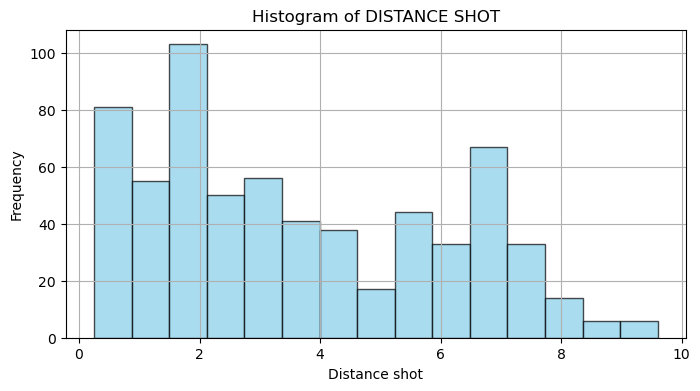

In [15]:
# HISTOGRAM OF DISTANCE SHOT

fig, ax = plt.subplots(figsize=(8, 4))  
df['dist_shot'].hist(bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Distance shot')
plt.ylabel('Frequency')
plt.title('Histogram of DISTANCE SHOT')
plt.show()


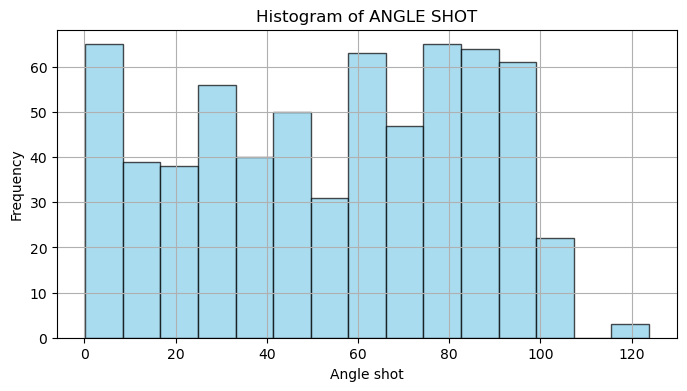

In [16]:
# HISTOGRAM OF ANGLE SHOT

fig, ax = plt.subplots(figsize=(8, 4))  
df['angle_shot'].hist(bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Angle shot')
plt.ylabel('Frequency')
plt.title('Histogram of ANGLE SHOT')
plt.show()

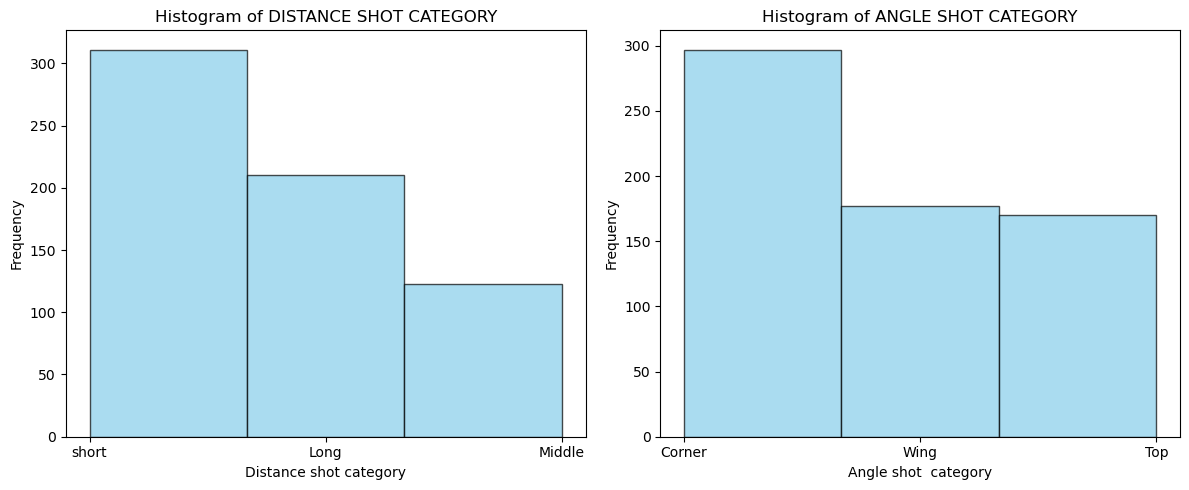

In [17]:
# HISTOGRAM OF ANGLE SHOT CATEGORY

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

axes[0].hist(df['dist_shot_cat'], bins=3, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Distance shot category')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of DISTANCE SHOT CATEGORY')

axes[1].hist(df['angle_shot_cat'], bins=3, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Angle shot  category')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of ANGLE SHOT CATEGORY')

plt.tight_layout()
plt.show()


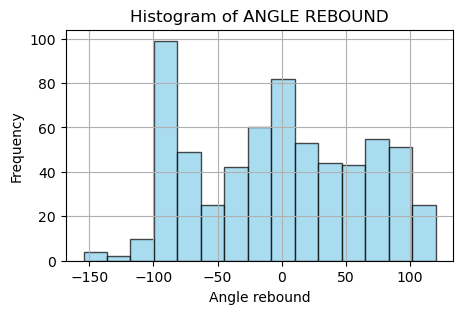

In [18]:
# HISTOGRAMA DE LA VARIABLE 'ANGLE_REBOUND'

fig, ax = plt.subplots(figsize=(5, 3))  
df['angle_rebound'].hist(bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Angle rebound')
plt.ylabel('Frequency')
plt.title('Histogram of ANGLE REBOUND')
plt.show()

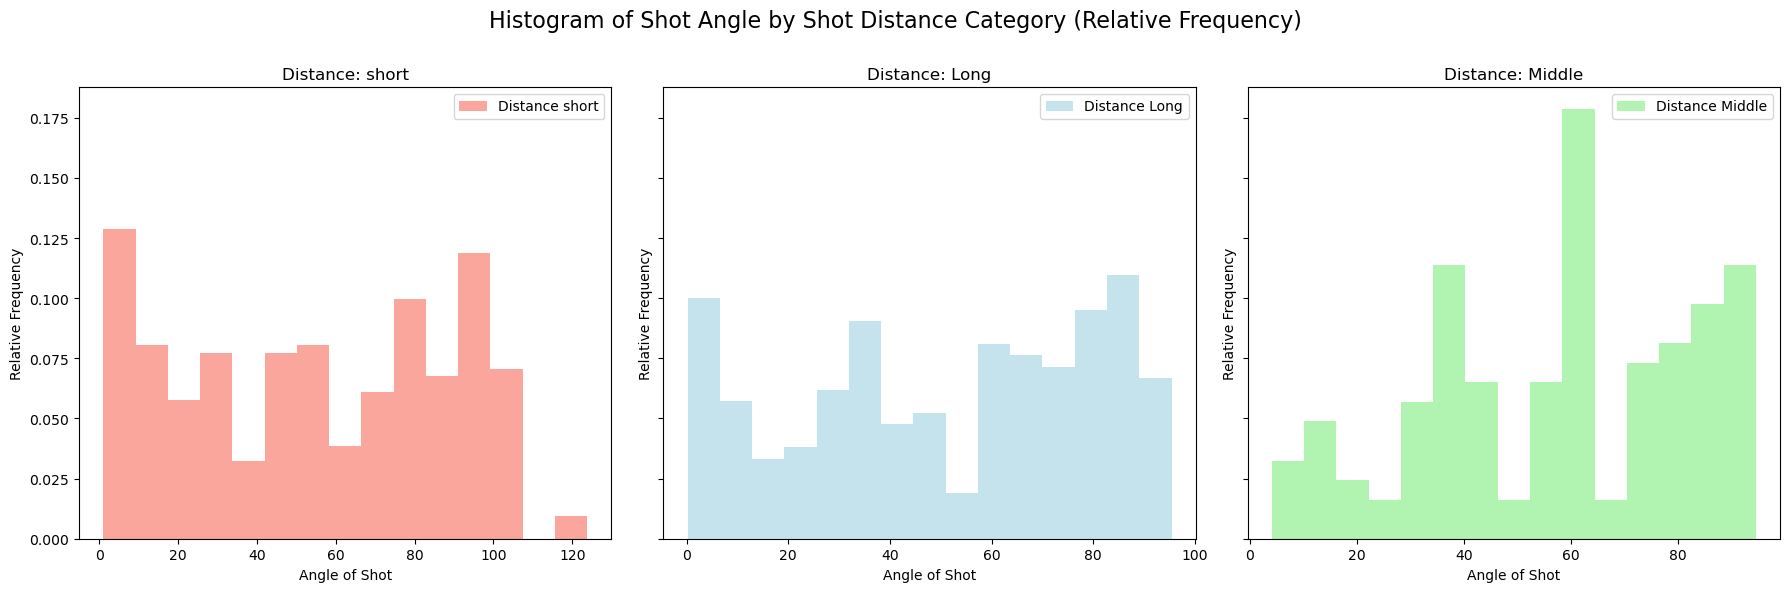

In [19]:
# HISTOGRAM OF THE SHOT ANGLE BY SHOT DISTANCE

colors = ['salmon', 'lightblue', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, category, color in zip(axes, df['dist_shot_cat'].unique(), colors):
    subset = df[df['dist_shot_cat'] == category]
    weights = np.ones_like(subset['angle_shot']) / len(subset)
    ax.hist(subset['angle_shot'], bins=15, weights=weights, alpha=0.7, color=color, label=f'Distance {category}')
    ax.set_title(f'Distance: {category}')
    ax.set_xlabel('Angle of Shot')
    ax.set_ylabel('Relative Frequency')
    ax.legend()

plt.tight_layout()
plt.suptitle('Histogram of Shot Angle by Shot Distance Category (Relative Frequency)', fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()


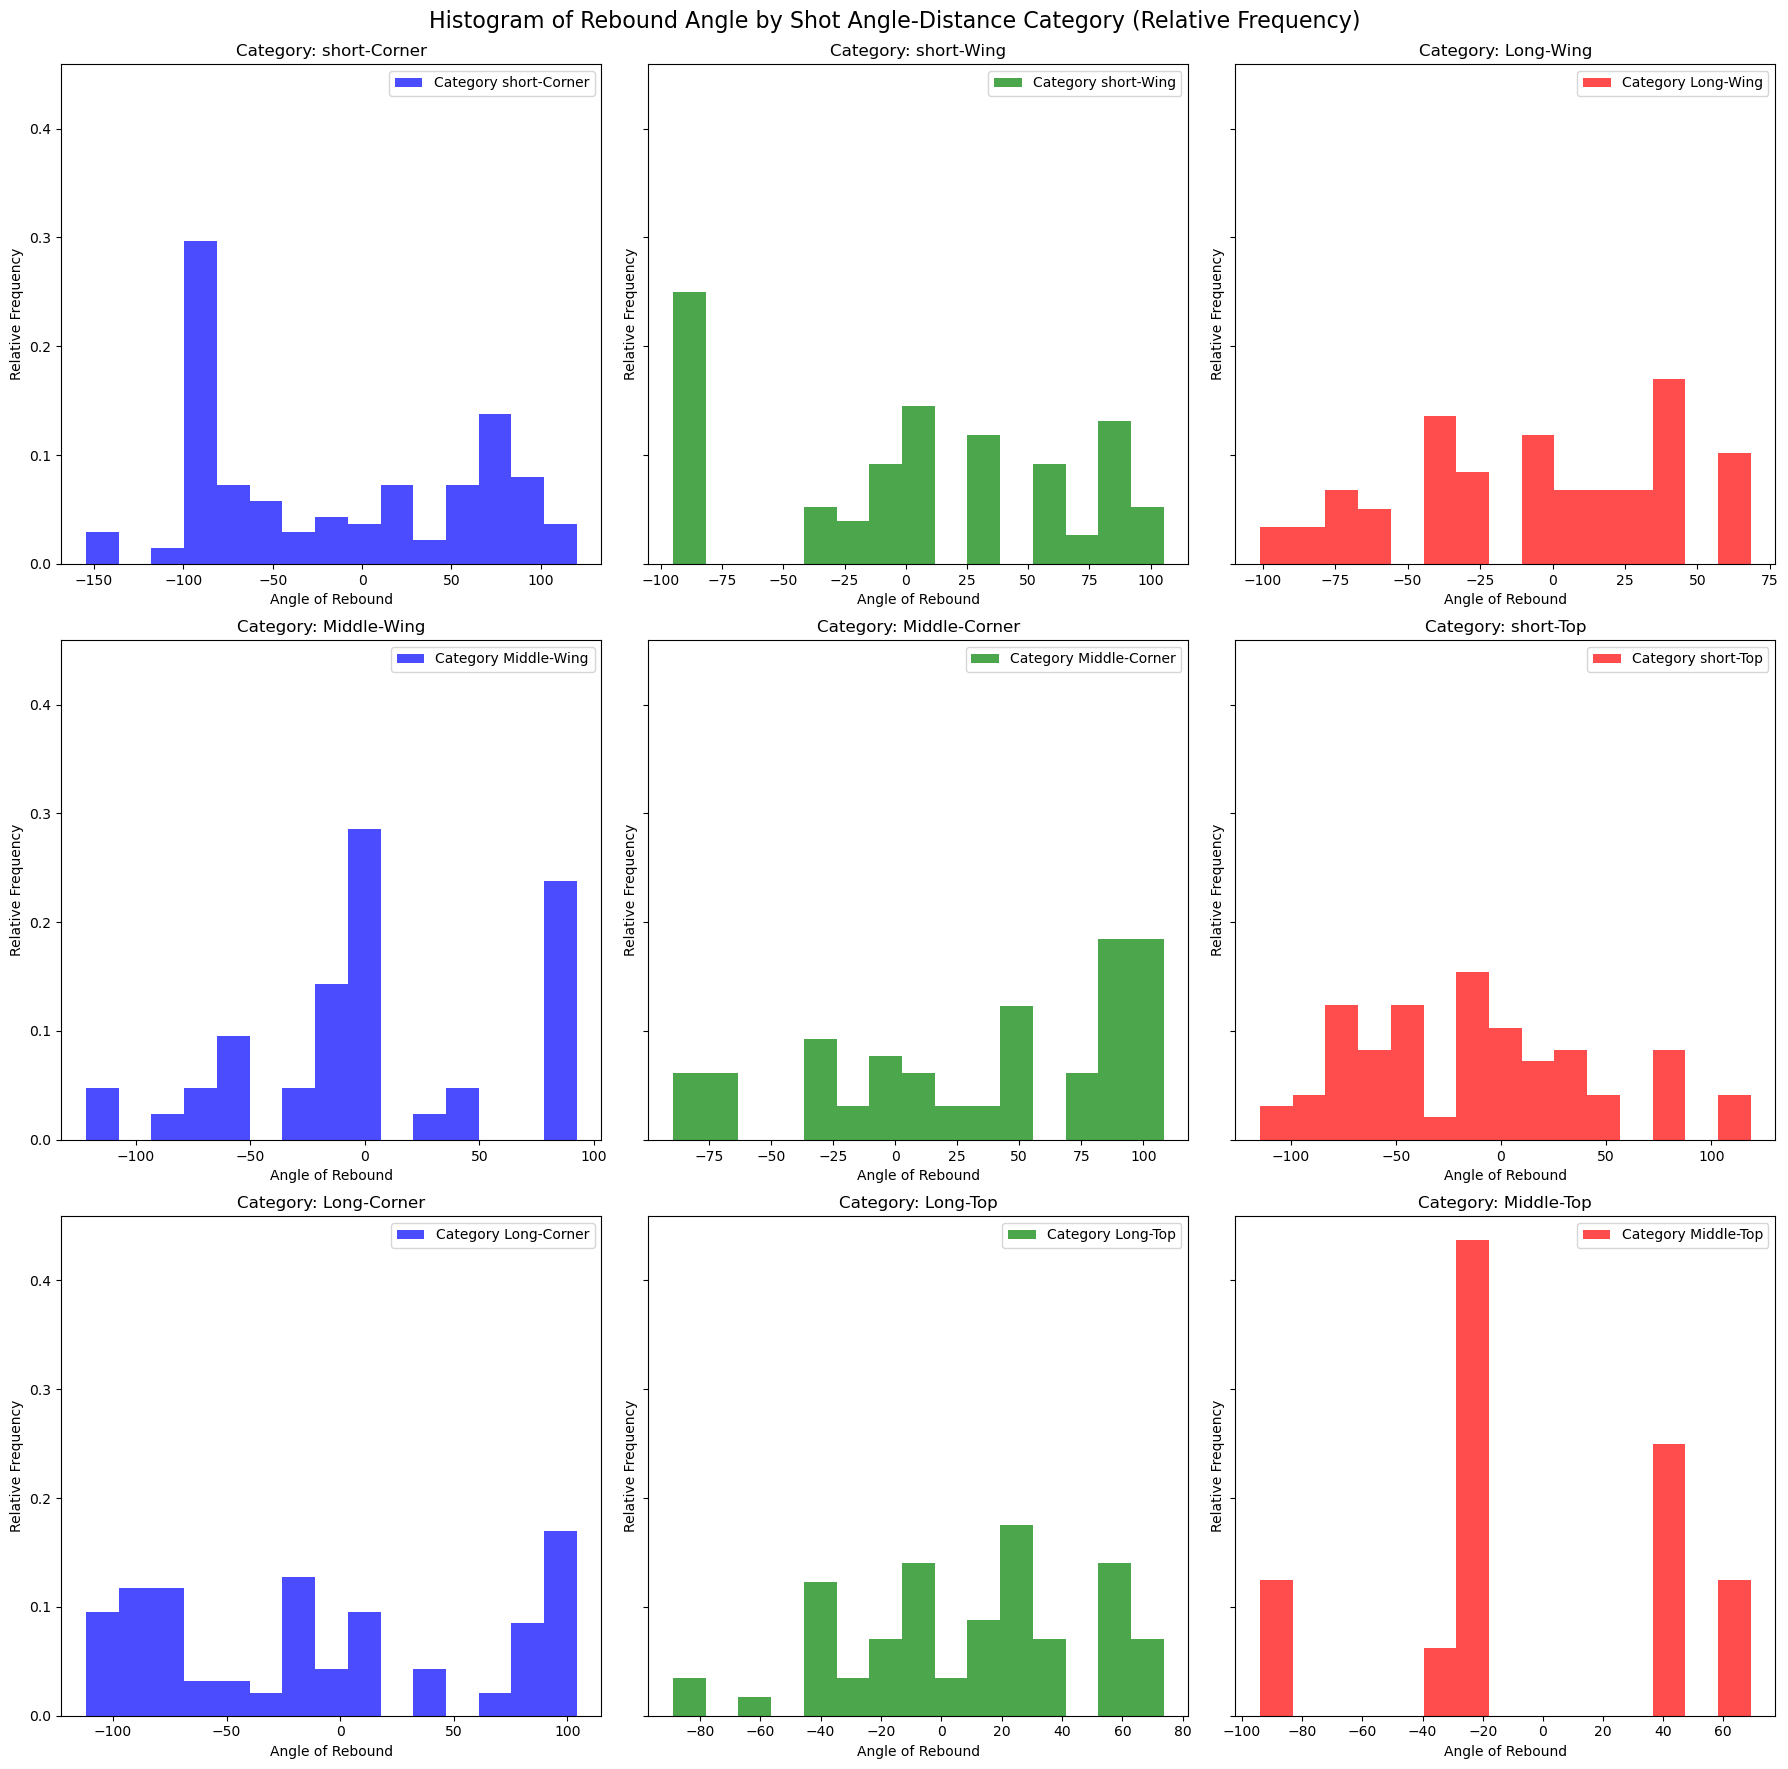

In [20]:
# HISTOGRAM OF THE REBOUND ANGLE BY SHOT ANGLE AND DISTANCE

fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharey=True)
colors = ['blue', 'green', 'red', 'blue', 'green', 'red', 'blue', 'green', 'red']

for ax, category, color in zip(axes.flatten(), df['angledist_shot_cat'].unique(), colors):
    subset = df[df['angledist_shot_cat'] == category]
    weights = np.ones_like(subset['angle_rebound']) / len(subset)
    ax.hist(subset['angle_rebound'], bins=15, weights=weights, alpha=0.7, color=color, label=f'Category {category}')
    ax.set_title(f'Category: {category}')
    ax.set_xlabel('Angle of Rebound')
    ax.set_ylabel('Relative Frequency')
    ax.legend()

plt.tight_layout()
plt.suptitle('Histogram of Rebound Angle by Shot Angle-Distance Category (Relative Frequency)', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()




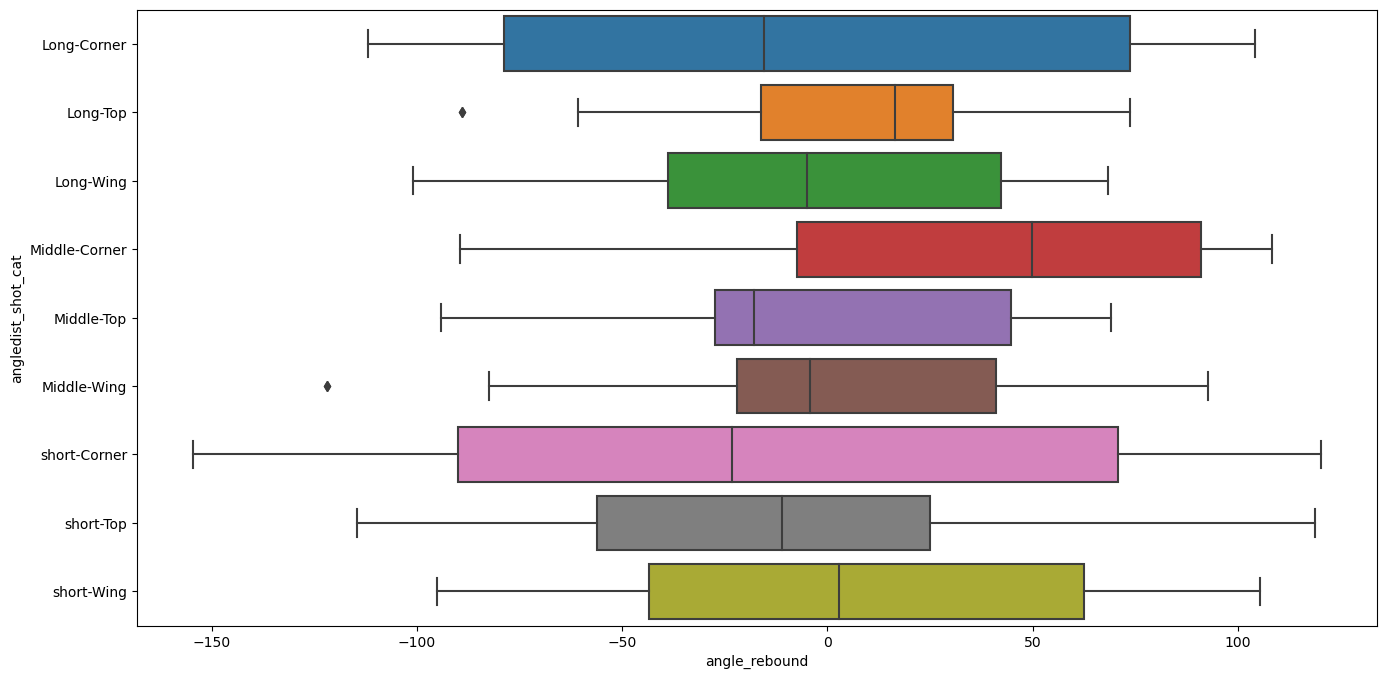

In [21]:
# BOXPLOT OF THE REBOUND ANGLE BY ANGLE-DISTANCE CATEGORIES OF THE SHOT

f, ax = plt.subplots(figsize=(16, 8))
order = sorted(df['angledist_shot_cat'].unique())
fig = sns.boxplot(x='angle_rebound', y='angledist_shot_cat', data=df, order = order)
plt.show()

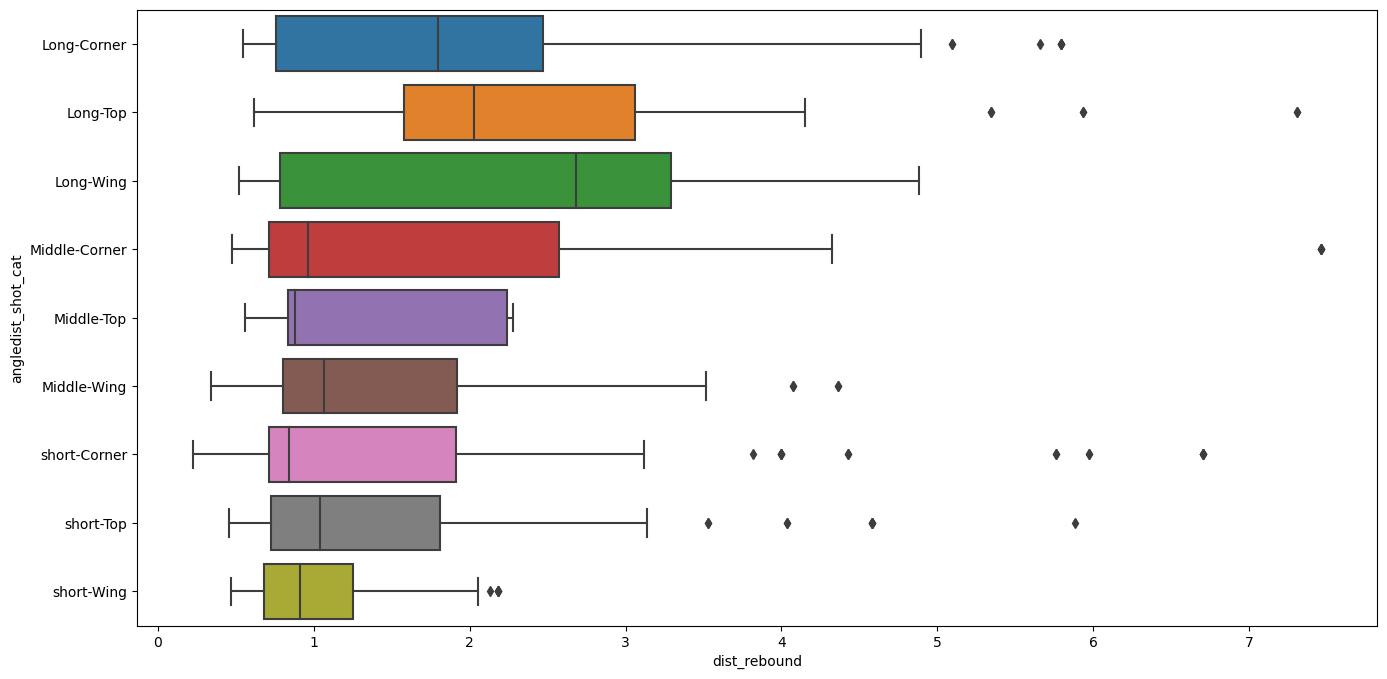

In [22]:
# BOXPLOT OF THE REBOUND DISTANCE BY ANGLE-DISTANCE CATEGORIES OF THE SHOT

f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='dist_rebound', y='angledist_shot_cat', data=df, order = order)
plt.show()

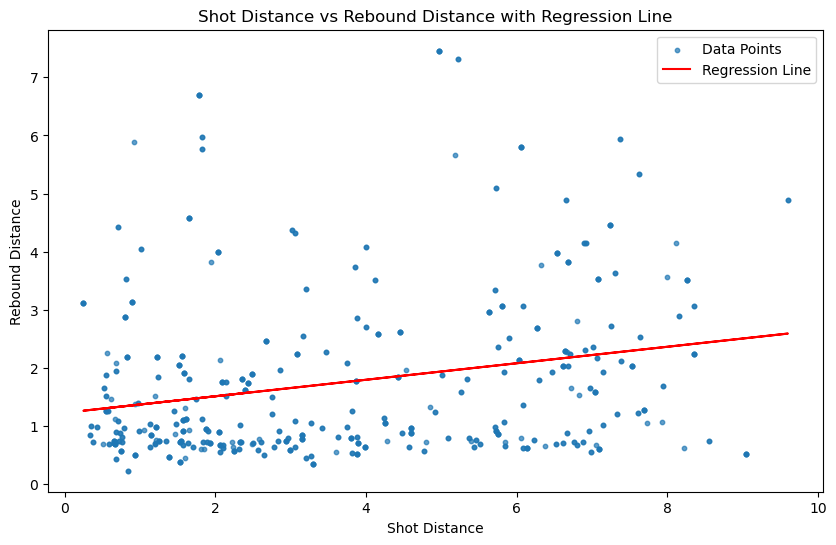

In [23]:
# DISPERSION GRAPH BETWEEN SHOT DISTANCE AND REBOUND DISTANCE

slope, intercept, r_value, p_value, std_err = stats.linregress(df['dist_shot'], df['dist_rebound'])
plt.figure(figsize=(10, 6))
plt.scatter(df['dist_shot'], df['dist_rebound'], s=10, alpha=0.7, label='Data Points')
plt.plot(df['dist_shot'], slope * df['dist_shot'] + intercept, color='red', label='Regression Line')

plt.xlabel('Shot Distance')
plt.ylabel('Rebound Distance')
plt.title('Shot Distance vs Rebound Distance with Regression Line')
plt.legend()

plt.show()

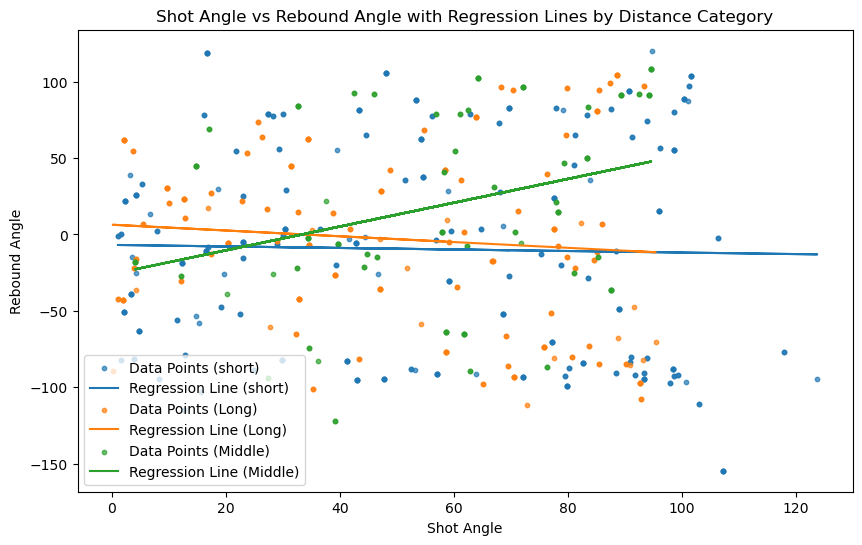

In [24]:
# DISPERSION GRAPH BETWEEN SHOT ANGLE AND REBOUND ANGLE DISTRIBUTED BY DISTANCE

plt.figure(figsize=(10, 6))

for category in df['dist_shot_cat'].unique():
    subset = df[df['dist_shot_cat'] == category]
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset['angle_shot'], subset['angle_rebound'])
    plt.scatter(subset['angle_shot'], subset['angle_rebound'], s=10, alpha=0.7, label=f'Data Points ({category})')
    plt.plot(subset['angle_shot'], slope * subset['angle_shot'] + intercept, label=f'Regression Line ({category})')

plt.xlabel('Shot Angle')
plt.ylabel('Rebound Angle')
plt.title('Shot Angle vs Rebound Angle with Regression Lines by Distance Category')
plt.legend()
plt.show()

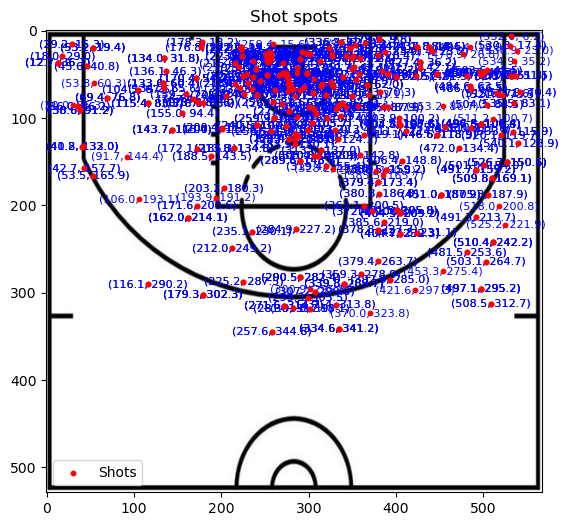

In [25]:
# SHOT CHART WITH COORDS OF THE SPOTS

court_img = mpimg.imread('images/basketball_halfcourt.jpg')
x_shot = df["x_shot"].tolist()
y_shot = df["y_shot"].tolist()

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(court_img)
ax.scatter(x_shot, y_shot, c='red', s=10, label='Shots', zorder=5)
for i, (x, y) in enumerate(zip(x_shot, y_shot)):
    ax.text(x, y, f'({x:.1f}, {y:.1f})', color='blue', fontsize=8, ha='center', va='center')

ax.set_title("Shot spots")
ax.legend()
plt.show()

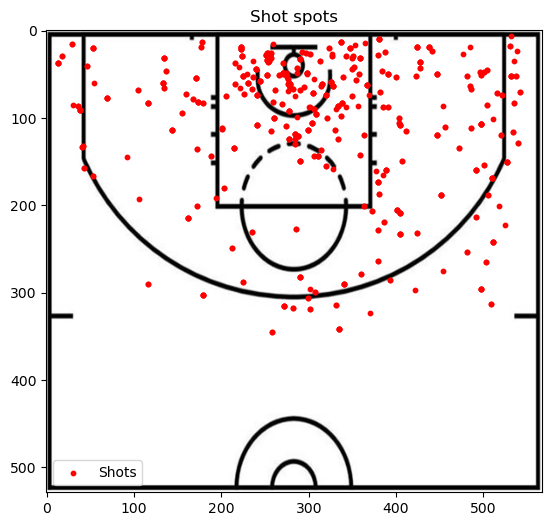

In [26]:
# SHOT CHART

court_img = mpimg.imread('images/basketball_halfcourt.jpg')

x_shot = df["x_shot"].tolist()
y_shot = df["y_shot"].tolist()

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(court_img)
ax.scatter(x_shot, y_shot, c='red', s=10, label='Shots', zorder=5)
ax.set_title("Shot spots")
ax.legend()
plt.show()


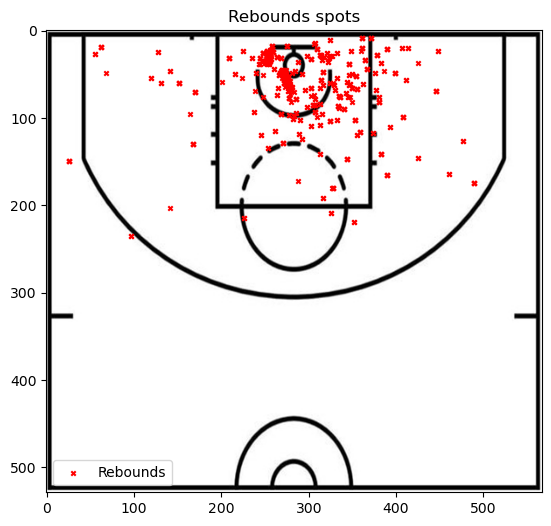

In [27]:
# REBOUND CHART

court_img = mpimg.imread('images/basketball_halfcourt.jpg')
x_rebound = df["x_rebound"].tolist()
y_rebound = df["y_rebound"].tolist()

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(court_img)
ax.scatter(x_rebound, y_rebound, c='red', marker='x', s=10, label='Rebounds', zorder=5)
ax.set_title("Rebounds spots")
ax.legend()
plt.show()

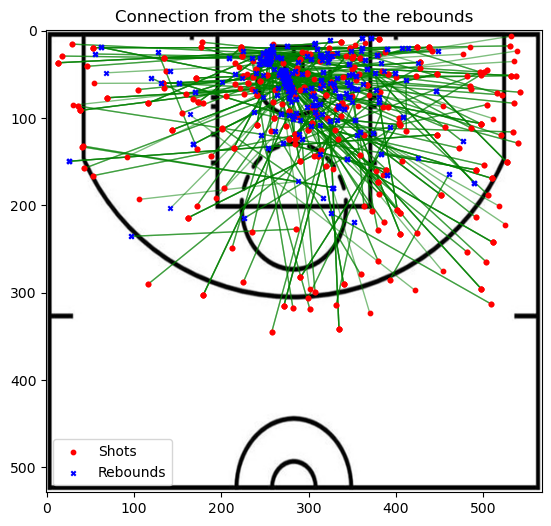

In [28]:
# GRAPH BETWEEN THE CONNECTION BETWEEN SHOTS AND REBOUNDS

court_img = mpimg.imread('images/basketball_halfcourt.jpg')
x_shot = df["x_shot"].tolist()
y_shot = df["y_shot"].tolist()
x_rebound = df["x_rebound"].tolist()
y_rebound = df["y_rebound"].tolist()


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(court_img)

ax.scatter(x_shot, y_shot, c='red', s=10, label='Shots', zorder=5)
ax.scatter(x_rebound, y_rebound, c='blue', marker='x', s=10, label='Rebounds', zorder=5)
for (x_s, y_s, x_r, y_r) in zip(x_shot, y_shot, x_rebound, y_rebound):
    ax.plot([x_s, x_r], [y_s, y_r], color='green', linewidth=1, alpha=0.5)

ax.set_title("Connection from the shots to the rebounds")
ax.legend()
plt.show()


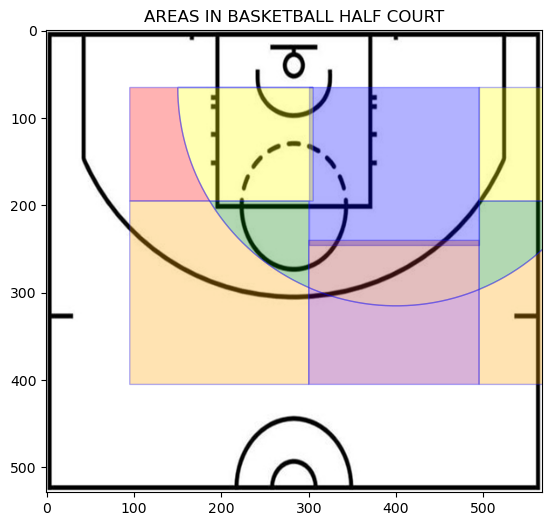

In [29]:
# AREAS IN BASKETBALL COURT

court_img = mpimg.imread('images/basketball_halfcourt.jpg')
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(court_img)

# DEFINE THE RECTANGLES OF THE COURT WITH SHAPELY POLYGONS
paint = Polygon([(300, 65), (495, 65), (495, 245), (300, 245)])
left_corner_rectangle = Polygon([(95, 65), (305, 65), (305, 195), (95, 195)])
right_corner_rectangle = Polygon([(495, 65), (705, 65), (705, 195), (495, 195)])
left_wing_rectangle = Polygon([(95, 195), (300, 195), (300, 405), (95, 405)])
right_wing_rectangle = Polygon([(495, 195), (700, 195), (700, 405), (495, 405)])
mid_rectangle = Polygon([(300, 240), (495, 240), (495, 405), (300, 405)]) 

# DEFINE THE SEMICIRCLE OF 3P
center = (400, 65)
radius = 250 
theta = np.linspace(0, np.pi, 100)
x = center[0] + radius * np.cos(theta)
y = center[1] + radius * np.sin(theta)
three_point_semicircle = Polygon(zip(x, y))

# 10 REGIONS
corner_left_2p = three_point_semicircle.intersection(left_corner_rectangle)
wing_left_2p = three_point_semicircle.intersection(left_wing_rectangle)
top_2p = three_point_semicircle.intersection(mid_rectangle)
wing_right_2p = three_point_semicircle.intersection(right_wing_rectangle)
corner_right_2p = three_point_semicircle.intersection(right_corner_rectangle)
corner_left_3p = left_corner_rectangle.difference(three_point_semicircle)
wing_left_3p = left_wing_rectangle.difference(three_point_semicircle)
top_3p = mid_rectangle.difference(three_point_semicircle)
wing_right_3p = right_wing_rectangle.difference(three_point_semicircle)
corner_right_3p = right_corner_rectangle.difference(three_point_semicircle)

# FUNCTION TO DRAW THE REGIONS
def plot_shapely_polygon(ax, geometry, edgecolor, facecolor, alpha=0.3):
    if geometry.is_empty:
        return
    if isinstance(geometry, Polygon):
        x, y = geometry.exterior.xy
        ax.add_patch(MplPolygon(list(zip(x, y)), closed=True, edgecolor=edgecolor, facecolor=facecolor, alpha=alpha))
    elif isinstance(geometry, LineString):
        x, y = geometry.xy
        ax.plot(x, y, color=edgecolor, alpha=alpha)

# DRAW THE REGIONS
plot_shapely_polygon(ax, paint, 'blue', 'blue')
plot_shapely_polygon(ax, corner_left_2p, 'blue', 'yellow')
plot_shapely_polygon(ax, corner_right_2p, 'blue', 'yellow')
plot_shapely_polygon(ax, corner_right_3p, 'blue', 'red')
plot_shapely_polygon(ax, corner_left_3p, 'blue', 'red')
plot_shapely_polygon(ax, wing_left_2p, 'blue', 'green')
plot_shapely_polygon(ax, wing_right_2p, 'blue', 'green')
plot_shapely_polygon(ax, wing_right_3p, 'blue', 'orange')
plot_shapely_polygon(ax, wing_left_3p, 'blue', 'orange')
plot_shapely_polygon(ax, top_3p, 'blue', 'purple')
plot_shapely_polygon(ax, top_2p, 'blue', 'brown')

ax.set_title("AREAS IN BASKETBALL HALF COURT")
plt.show()



C:\Users\Lluis\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


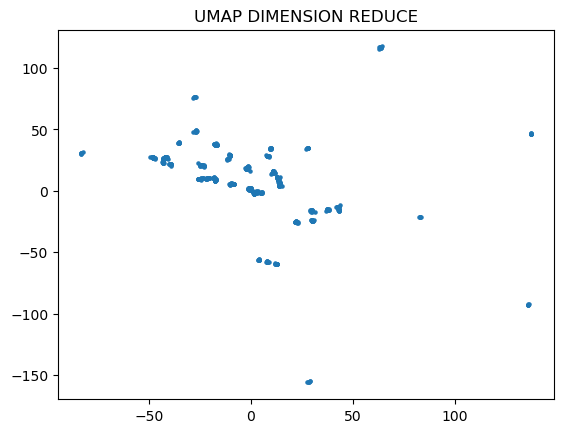

In [30]:
# DIMENSIONAL REDUCTION OF THE DATA USING UMAP AND VISUALIZE IT

df_reduce = df[["angle_shot", "angle_rebound", "dist_shot", "dist_rebound"]]
umap_model = umap.UMAP(n_components=2, learning_rate=100)
umap_resultat = umap_model.fit_transform(df_reduce)

plt.scatter(umap_resultat[:, 0], umap_resultat[:, 1], marker='o', s=5)
plt.title('UMAP DIMENSION REDUCE')
plt.show()


C:\Users\Lluis\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Lluis\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Lluis\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Lluis\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

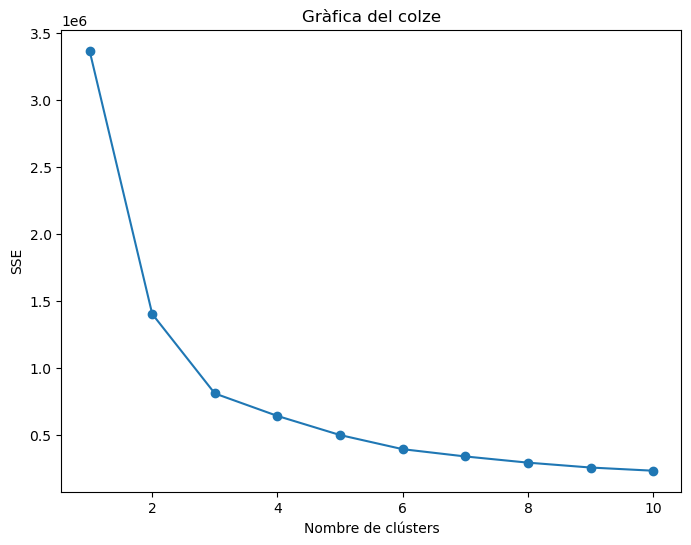

In [31]:
# ELBOW TEST TO DO K-MEANS AFTERWARDS

X = umap_resultat
y = df['dist_shot_cat']

sse = []

for k in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(df_reduce)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Gràfica del colze')
plt.xlabel('Nombre de clústers')
plt.ylabel('SSE')
plt.show()

C:\Users\Lluis\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


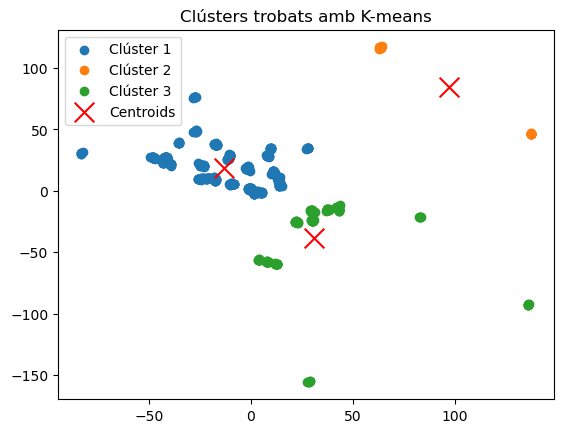

In [32]:
# APPLICATION OF THE K-MEANS

kmeans = cluster.KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

for i in range(3):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], label=f'Clúster {i + 1}')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.title('Clústers trobats amb K-means')
plt.legend()
plt.show()

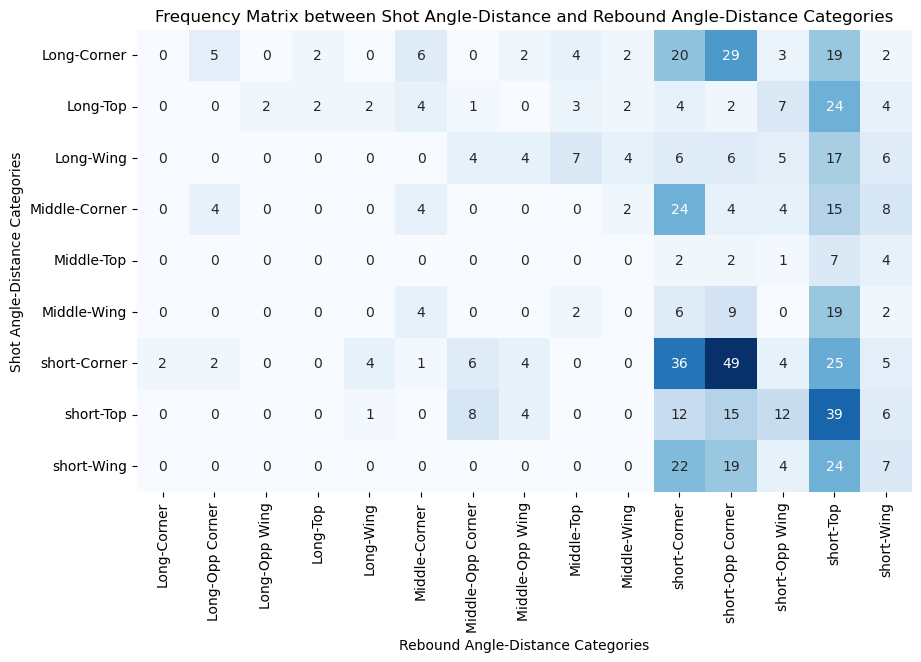

In [33]:
# FREQUENCES HEATMAP MATRIX FOR THE CATEGORIES ANGLE-DISTANCE OF THE SHOTS AND THE CATEGORIES ANGLE-DISTANCE OF THE REBOUNDS

matrix = pd.crosstab(df['angledist_shot_cat'], df['angledist_rebound_cat'])
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Frequency Matrix between Shot Angle-Distance and Rebound Angle-Distance Categories')
plt.xlabel('Rebound Angle-Distance Categories')
plt.ylabel('Shot Angle-Distance Categories')
plt.show()


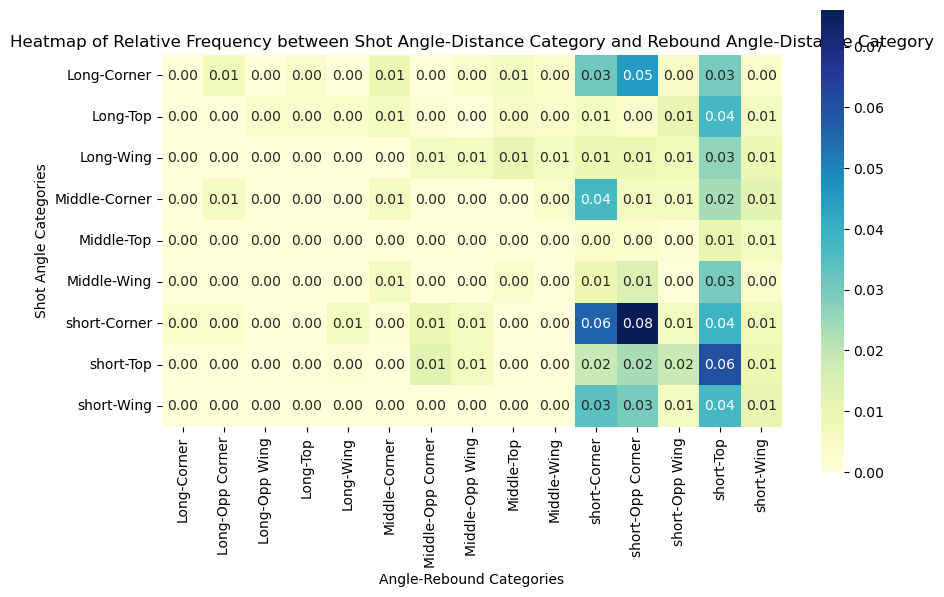

In [34]:
# RELATIVE HEATMAP FREQUENCES MATRIX FOR THE CATEGORIES ANGLE-DISTANCE OF THE SHOTS AND THE CATEGORIES ANGLE-DISTANCE OF THE REBOUNDS

matrix = pd.crosstab(df['angledist_shot_cat'], df['angledist_rebound_cat'], normalize='all')
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, square=True)

plt.xlabel('Angle-Rebound Categories')
plt.ylabel('Shot Angle Categories')
plt.title('Heatmap of Relative Frequency between Shot Angle-Distance Category and Rebound Angle-Distance Category')

plt.show()


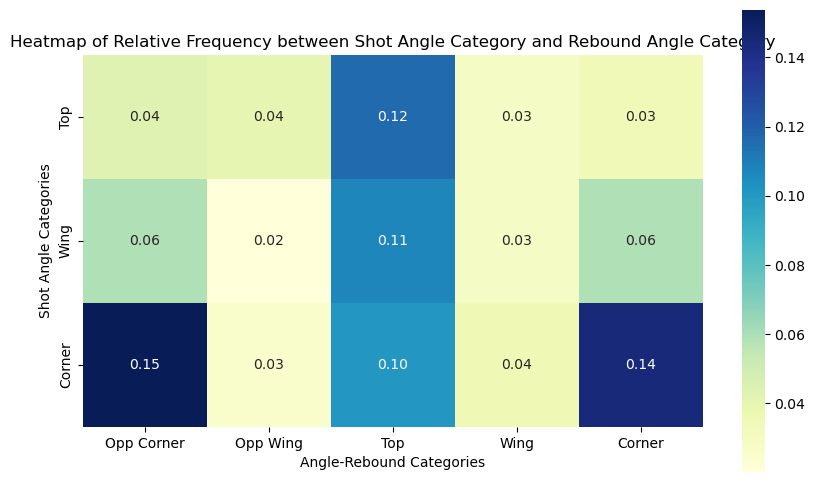

In [35]:
# RELATIVE HEATMAP FREQUENCES MATRIX FOR THE CATEGORIES ANGLE SHOT AND THE CATEGORIES ANGLE REBOUND

matrix = pd.crosstab(df['angle_shot_cat'], df['angle_rebound_cat'], normalize='all')

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, square=True)

plt.xlabel('Angle-Rebound Categories')
plt.ylabel('Shot Angle Categories')
plt.title('Heatmap of Relative Frequency between Shot Angle Category and Rebound Angle Category')

plt.show()


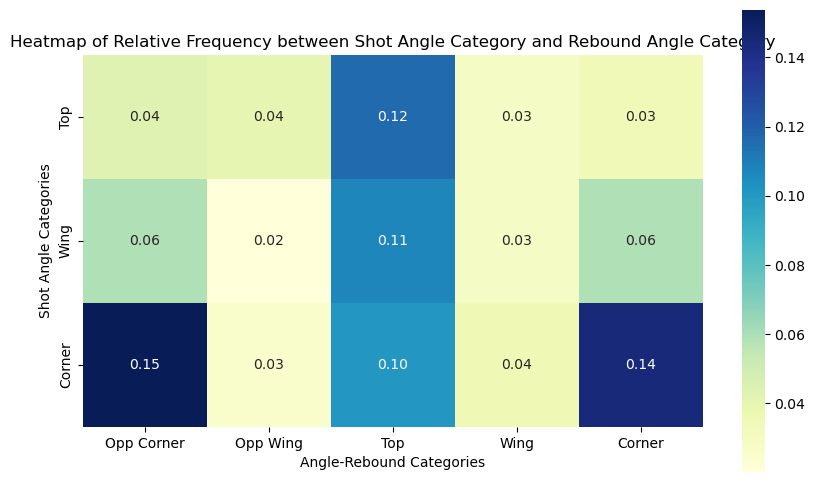

In [36]:
# RELATIVE HEATMAP FREQUENCES MATRIX FOR THE CATEGORIES ANGLE SHOT AND THE CATEGORIES ANGLE REBOUND

matrix = pd.crosstab(df['angle_shot_cat'], df['angle_rebound_cat'], normalize='all')

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, square=True)

plt.xlabel('Angle-Rebound Categories')
plt.ylabel('Shot Angle Categories')
plt.title('Heatmap of Relative Frequency between Shot Angle Category and Rebound Angle Category')

plt.show()


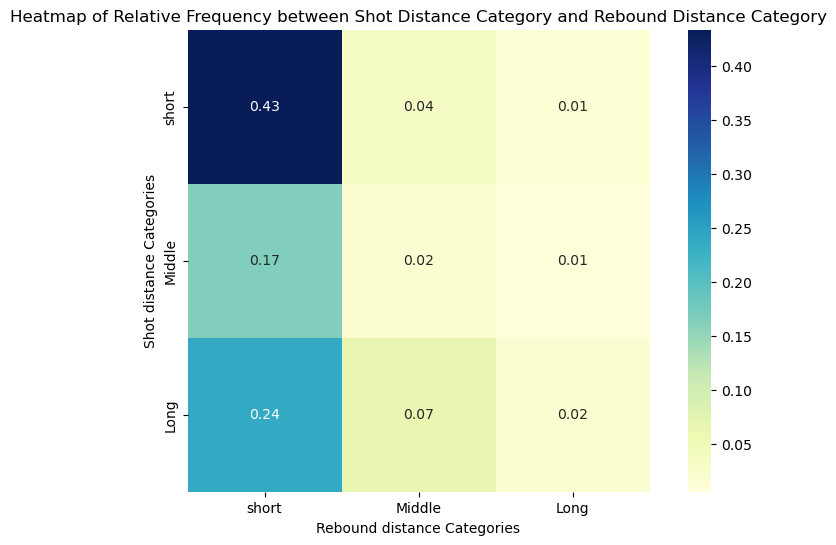

In [37]:
# RELATIVE HEATMAP FREQUENCES MATRIX FOR THE CATEGORIES DISTANCE SHOT AND THE CATEGORIES DISTANCE REBOUND

# Crear una matriz de frecuencias entre las categorías de 'angledist_shot_cat' y 'angledist_rebound_cat'
matrix = pd.crosstab(df['dist_shot_cat'], df['dist_rebound_cat'], normalize='all')

# Crear el mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True, square=True)

# Etiquetas y título
plt.xlabel('Rebound distance Categories')
plt.ylabel('Shot distance Categories')
plt.title('Heatmap of Relative Frequency between Shot Distance Category and Rebound Distance Category')

plt.show()

